In [25]:
from qc import *

In [26]:
def c_amod15(a, power):
  """Controlled multiplication by a mod 15"""
  if a not in [2,7,8,11,13]:
    raise ValueError("'a' must be 2,7,8,11 or 13")
  U = QuantumCircuit(4)        
  for iteration in range(power):
    if a in [2,13]:
      U.swap(0,1)
      U.swap(1,2)
      U.swap(2,3)
    if a in [7,8]:
      U.swap(2,3)
      U.swap(1,2)
      U.swap(0,1)
    if a == 11:
      U.swap(1,3)
      U.swap(0,2)
    if a in [7,11,13]:
      for q in range(4):
        U.x(q)
  U = U.to_gate()
  U.name = "%i^%i mod 15" % (a, power)
  c_U = U.control()
  return c_U


In [27]:
#variables
n_count = 8 # number of counting bits
a = 11

In [28]:
qc = QuantumCircuit(n_count + 4, n_count)
#init counting qubits to |+>
for q in range(n_count):
  qc.h(q)

#init aux register to |1>
qc.x(3+n_count)

#C-U
for q in range(n_count):
  qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])

#inverse qft
qft_dagger(qc, n_count)

qc.measure(range(n_count), range(n_count))
qc.draw(fold=160)
# qc.draw()

┌───┐                                                                                                                                        ┌───┐»
 q_0: ┤ H ├───────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X─┤ H ├»
      ├───┤       │                                                                                                                              │ └───┘»
 q_1: ┤ H ├───────┼───────────────■───────────────────────────────────────────────────────────────────────────────────────────────────X──────────┼──────»
      ├───┤       │               │                                                                                                   │          │      »
 q_2: ┤ H ├───────┼───────────────┼───────────────■──────────────────────────────────────────────────────────────────X────────────────┼──────────┼──────»
      ├───┤       │               │               │                                                                  │                │          │      »
 q_3: ┤ H ├───────┼───────────────┼───────────────┼───────────────■─────────────────────────────────X────────────────┼────────────────┼──────────┼──────»
      ├───┤       │               │               │               │                                 │                │                │          │      »
 q_4: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────■────────────────X────────────────┼────────────────┼──────────┼──────»
      ├───┤       │               │               │               │                │                                 │                │          │      »
 q_5: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────■────────────────X────────────────┼──────────┼──────»
      ├───┤       │               │               │               │                │                │                                 │          │      »
 q_6: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────■────────────────X──────────┼──────»
      ├───┤       │               │               │               │                │                │                │                           │      »
 q_7: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────┼────────────────■──────────X──────»
      └───┘┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴────────┐        »
 q_8: ─────┤0             ├┤0             ├┤0             ├┤0             ├┤0              ├┤0              ├┤0              ├┤0               ├────────»
           │              ││              ││              ││              ││               ││               ││               ││                │        »
 q_9: ─────┤1             ├┤1             ├┤1             ├┤1             ├┤1              ├┤1              ├┤1              ├┤1               ├────────»
           │  11^1 mod 15 ││  11^2 mod 15 ││  11^4 mod 15 ││  11^8 mod 15 ││  11^16 mod 15 ││  11^32 mod 15 ││  11^64 mod 15 ││  11^128 mod 15 │        »
q_10: ─────┤2             ├┤2             ├┤2             ├┤2             ├┤2              ├┤2              ├┤2              ├┤2               ├────────»
      ┌───┐│              ││              ││              ││              ││               ││               ││               ││                │        »
q_11: ┤ X ├┤3             ├┤3             ├┤3             ├┤3             ├┤3              ├┤3              ├┤3              ├┤3               ├────────»
      └───┘└──────────────┘└──────────────┘└──────────────┘└──────────────┘└───────────────┘└───────────────┘└───────────────┘└────────────────┘        »
 c: 8/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
  

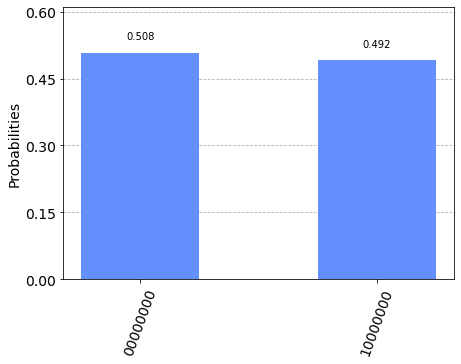

In [29]:
counts = simulate(qc)
plot_histogram(counts)

In [30]:
import pandas as pd

In [31]:
rows, phases = [], []
for output in counts:
  decimal = int(output, 2)
  phase = decimal/(2**n_count)
  phases.append(phase)
  rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{decimal}/{2**n_count} = {phase:.2f}"])
headers = ["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  00000000(bin) =   0(dec)    0/256 = 0.00


In [32]:
from fractions import Fraction

In [33]:
rows = []
for phase in phases:
  frac = Fraction(phase).limit_denominator(15)
  rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0    0.5      1/2            2
1    0.0      0/1            1
